In [1]:
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image

import os
import numpy as np
from PIL import Image, ImageOps

from glob import glob
import h5py
from tqdm.auto import tqdm

Extraction of classes
We will be classifying images based on US State
This info is contained within the metadata file aquired with the images

The original metadata file is quite large so we will aim to reduce it asap, by only retaining images we are using for this project
The method used is not very fast however, but since it will only be done once for preprocessing it is deemed acceptable

In [2]:
imageList = os.listdir("data")
classes = ['FL', 'CA', 'NM', 'ME']
out_dir = "processed"
images = []

In [3]:
import pandas as pd
repeatMeta = False

if repeatMeta:
    metadata = pd.read_csv("metadata.csv", engine='python')
    metadataShort = pd.DataFrame(columns=metadata.columns)

    for i in tqdm(imageList):
        relMeta = metadata.loc[metadata['NAIP Entity ID'].str.contains(i[:15], case=False)].drop_duplicates(subset=['State'], keep='last')
        relMeta = relMeta.loc[relMeta['State'].isin(classes)]   #Check if acceptable class
        metadataShort = metadataShort.append(relMeta, ignore_index = True)   #For record

    metadataShort.to_csv("metadataShort.csv")
    del metadata, relMeta  #To clear up memory 

else:
    metadataShort = pd.read_csv("metadataShort.csv", engine='python')

labels = metadataShort["State"]

In [ ]:
def extractImage(source,jp2,target = None,pix = 1024):
    f = rasterio.open(source + jp2)  #Open Image
    CMYK = np.uint8(reshape_as_image(f.read())) #Convert to standard image format
    I = Image.fromarray(CMYK).resize((pix, pix))
    if target != None:
        I.save(target + jp2[:-4] + ".png",optimize=True,quality=20)
    return  np.array(I)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [ ]:
from sample import sample_images

for c,img in enumerate(tqdm(imageList)):
    try:
        #image = extractImage("data/",img,"dataHuman/")
        image = extractImage("data/",img)
        samples,corners = sample_images([image], 20, [128,128,4], 20)

        for i, (sample, corner) in enumerate(zip(samples, corners)):
                export_name = f"{labels[c]}_{c}_{i}"
                h5_file = h5py.File(f"{out_dir}/{export_name}.h5", "w-")
                dset = h5_file.create_dataset("IMG", sample[0].shape, compression="gzip")
                dset[...] = sample[0]
                dset.attrs["x"] = corner[0]
                dset.attrs["y"] = corner[1]
                dset.attrs["z"] = corner[2]
                h5_file.close()
    except:
        pass

In [4]:
sampleList = os.listdir("processed")

In [6]:
import matplotlib.pyplot as plt
from numpy.random import randint

def load_sample(file_name):
    h5_file = h5py.File(file_name, "r")
    img = h5_file["IMG"][:]
    h5_file.close()
    return img

def imgRGBConverter(In):
    from PIL import Image
    image = Image.fromarray(np.uint8(In))
    image.mode = "CMYK"
    return(np.array(image.convert('RGB')))



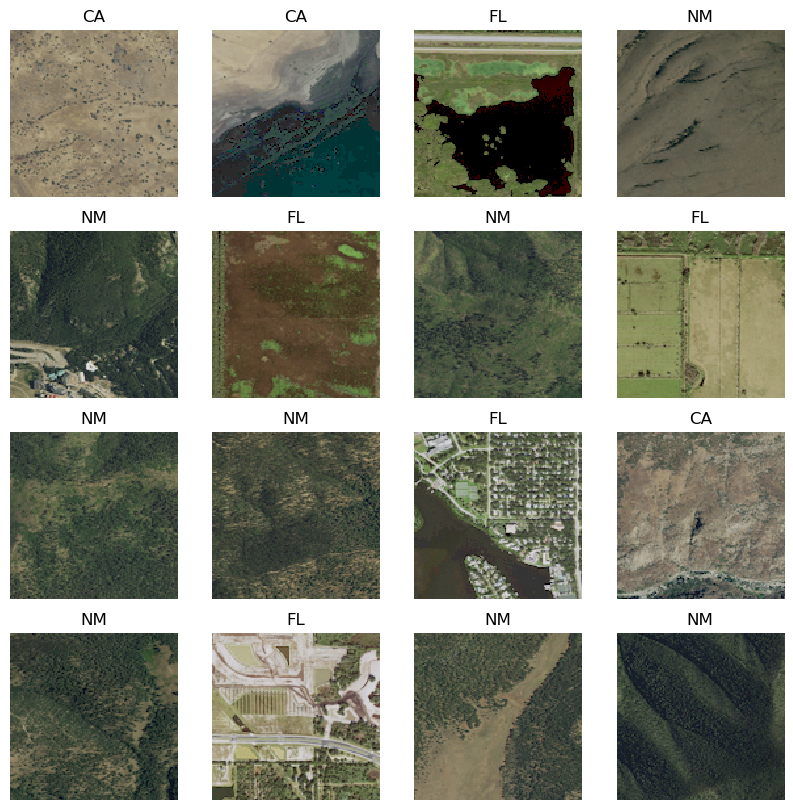

In [7]:
plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)

    sel = sampleList[randint(0, len(sampleList))]
    img = load_sample("processed/" + sel, sel[:2])
    img = imgRGBConverter(img)

    plt.imshow(img.astype("uint8"))
    plt.title(str(sel[:2]))
    plt.axis("off")
plt.show()

In [26]:
## LOAD DATA FOR SPLITTING

sampleList = os.listdir("processed")
samples = []
labels = []

for i in tqdm(sampleList):
    samples.append(load_sample("processed/" + i, i[:2]))
    labels.append(classes.index(i[:2]))

from sklearn.model_selection import train_test_split

img_train, img_vali, lab_train, lab_vali = train_test_split(samples, labels, stratify=labels, test_size=0.3)

img_vali, img_test, lab_vali, lab_test = train_test_split(samples, labels, stratify=labels, test_size=0.3)


100%|██████████| 1380/1380 [00:02<00:00, 588.37it/s]


In [27]:
## START UP TF CUDA
import tensorflow as tf 

gpus = tf.config.list_physical_devices('GPU')
assert len(gpus) > 0
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


In [28]:
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((img_train, lab_train)).batch(batch_size).shuffle(len(img_train), reshuffle_each_iteration=True).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((img_vali, lab_vali)).batch(batch_size).shuffle(len(img_test), reshuffle_each_iteration=True)


In [29]:
from tensorflow.keras import layers, Sequential

num_classes = len(classes)
img_height = 128
img_width = 128

data_augmentation = Sequential(
  [
     layers.RandomFlip(), 
  layers.RandomRotation(0.1), 
  ]
)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 4)),
  layers.Conv2D(16, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
epochs=100
history = model.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=epochs
)

Epoch 1/100
61/61 [==============================] - 3s 31ms/step - loss: 0.9699 - accuracy: 0.5311 - val_loss: 0.8376 - val_accuracy: 0.5663
Epoch 2/100
61/61 [==============================] - 2s 25ms/step - loss: 0.6165 - accuracy: 0.7298 - val_loss: 0.8031 - val_accuracy: 0.6232
Epoch 3/100
61/61 [==============================] - 2s 25ms/step - loss: 0.5771 - accuracy: 0.7629 - val_loss: 0.5898 - val_accuracy: 0.7298
Epoch 4/100
61/61 [==============================] - 2s 25ms/step - loss: 0.4823 - accuracy: 0.8043 - val_loss: 0.3677 - val_accuracy: 0.8395
Epoch 5/100
61/61 [==============================] - 2s 26ms/step - loss: 0.3794 - accuracy: 0.8571 - val_loss: 0.5642 - val_accuracy: 0.7360
Epoch 6/100
61/61 [==============================] - 2s 27ms/step - loss: 0.3725 - accuracy: 0.8571 - val_loss: 0.2648 - val_accuracy: 0.9048
Epoch 7/100
61/61 [==============================] - 2s 26ms/step - loss: 0.3214 - accuracy: 0.8716 - val_loss: 0.6747 - val_accuracy: 0.6832
Epoch 

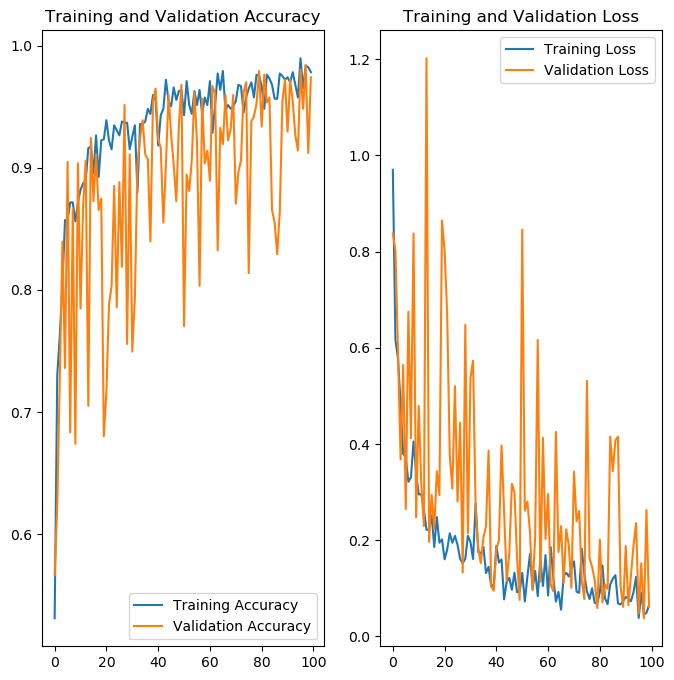

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
import random
randomlist = random.sample(range(0, len(img_test)), 5)

for i in randomlist:

    img_array = tf.expand_dims(img_test[i], 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image from class: {}, most likely belongs to {} with a {:.2f} percent confidence."
        .format(classes[lab_test[i]],classes[np.argmax(score)], 100 * np.max(score))
    )

    

This image from class: NM, most likely belongs to NM with a 99.08 percent confidence.
This image from class: NM, most likely belongs to NM with a 99.58 percent confidence.
This image from class: NM, most likely belongs to NM with a 100.00 percent confidence.
This image from class: FL, most likely belongs to FL with a 99.99 percent confidence.
This image from class: FL, most likely belongs to FL with a 99.95 percent confidence.


In [33]:
zip(img_test,lab_test)